In [115]:
import pandas as pd
import numpy as np
from gurobipy import *

In [110]:
# cargar la cinética de recuperacion
data_name = 'marvin'
cinetica_path = '/Users/administrador2/Desktop/Memoria/Codigos/Daniel_inputs/'
block_path = '/Users/administrador2/Desktop/Memoria/Codigos/minelib_inputs/marvin.blocks'
cinetica_file = 'REC_MODEL_T240.csv'
cinetica_df = pd.read_csv(cinetica_path + cinetica_file)
blocks_df = pd.read_csv(block_path, header=None)
rec = cinetica_df['rec90'] # panda series para la recuperacion en t=90

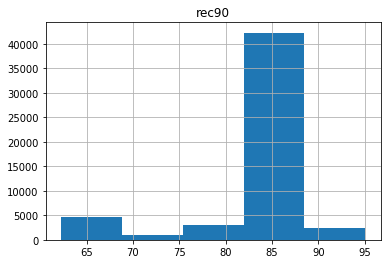

In [172]:
# histograma de la recuperacion en el instante 90
hist = cinetica_df.hist(column='rec90', bins=5)
# calcular nuevos valores de la funcion objetivo
# usando la recuperación al dia 90
nblocks = blocks_df.shape[0]
# algunos datos dados
c_conv = 2204.62
rec_AU = 0.88
price_AU = 12
seilling_AU = 0.2
rec_CU = 0.75
price_CU = 20
seilling_CU = 7.2
proc_cost = 4
mine_cost = 0.9 # por tonn
bv_list_cinetic = list()
bv_list = list()
bv_list_calc = list()
economic_value_list = list()
economic_value_rec_list = list()
with open('marvin_cinetica.upit', 'w') as output, open(block_path, 'r') as bm:
    output.write('NAME: marvin\nTYPE: UPIT\nNBLOCKS: 53271\nOBJECTIVE_FUNCTION: \n')
    for i in range(nblocks):
        #recuperar datos de bm para calcular valor de cada bloque
        linea_bm = bm.readline()
        linea_lista = linea_bm.split()
        tonn = float(linea_lista[4])
        AU = float(linea_lista[5])
        CU = float(linea_lista[6])
        proc_profit_cinetic = AU*rec_AU*(price_AU-seilling_AU) + CU*rec[i]/100*(price_CU-seilling_CU)-proc_cost
        proc_profit_calc = AU*rec_AU*(price_AU-seilling_AU) + CU*rec_CU*(price_CU-seilling_CU)-proc_cost
        economic_value = (AU*rec_AU*(price_AU-seilling_AU) + CU*rec[i]/100*(price_CU-seilling_CU)-(mine_cost+proc_cost))*tonn
        economic_value_rec = (AU*rec_AU*(price_AU-seilling_AU) + CU*rec_CU*(price_CU-seilling_CU)-(mine_cost+proc_cost))*tonn
        block_value_cinetic = proc_profit_cinetic*mine_cost*tonn
        block_value_calc = proc_profit_calc*mine_cost*tonn
        bv_list_cinetic.append(block_value_cinetic)
        bv_list_calc.append(block_value_calc)
        economic_value_list.append(economic_value)
        economic_value_rec_list.append(economic_value_rec)
        output.write('%i %f\n' % (i, block_value))

In [158]:
upit_path = '/Users/administrador2/Desktop/Memoria/Codigos/minelib_inputs/marvin.upit'
with open(upit_path, 'r') as f:
    for i in range(4):
        f.readline()
    for line in f:
        if not line == 'EOF\n':
            lista = line.split()
            bv_list.append(float(lista[1]))

In [91]:
pcpsp_path = '/Users/administrador2/Desktop/Memoria/Codigos/minelib_inputs/newman1.pcpsp'
with open(pcpsp_path, 'r') as f:
    for i,linea in enumerate(f):
        if split
        if i > 6:
            break

NAME: Newman1

TYPE: PCPSP

NBLOCKS: 1060

NPERIODS: 6

NDESTINATIONS: 2

NRESOURCE_SIDE_CONSTRAINTS: 2

NGENERAL_SIDE_CONSTRAINTS: 0

DISCOUNT_RATE: 0.08



In [95]:
cinetica_df['rec90'].mean()

84.2149523192683

In [120]:
# beneficio con recuperacion de Daniel y calculo posterior 
m = Model()
# variable de desicion para el modelo
x = {}
for i in range(nblocks):
    x[i] = m.addVar(vtype=GRB.BINARY, name = "x%d" % i)
m.update()
# definir objetivo
m.setObjective(quicksum(bv_list_cinetic[i]*x[i] for i in range(nblocks)), GRB.MAXIMIZE)
# definir restricciones
prec_path = '/Users/administrador2/Desktop/Memoria/Codigos/minelib_inputs/marvin.prec'
with open(prec_path, 'r') as f:
    for linea in f:
        linea_lista = linea.split()
        nvecinos = int(linea_lista[1])
        u = int(linea_lista[0])
        for j in range(nvecinos):
            v = int(linea_lista[j+2])
            m.addConstr(x[u] <= x[v])
m.optimize()

Optimize a model with 650631 rows, 53271 columns and 1301262 nonzeros
Variable types: 0 continuous, 53271 integer (53271 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+08]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 7.704371e+08
Found heuristic solution: objective 1.664118e+11
Presolve removed 525080 rows and 41122 columns (presolve time = 5s) ...
Presolve removed 553117 rows and 43058 columns (presolve time = 10s) ...
Presolve removed 561343 rows and 44294 columns (presolve time = 16s) ...
Presolve removed 580218 rows and 45063 columns
Presolve time: 17.62s
Presolved: 70413 rows, 8208 columns, 140826 nonzeros
Found heuristic solution: objective 1.192366e+11
Found heuristic solution: objective 1.739652e+11
Variable types: 0 continuous, 8208 integer (8208 binary)
Presolved: 8208 rows, 78621 columns, 149034 nonzeros

Presolve removed 8208 rows and 78621 columns

Root simplex log..

In [168]:
# beneficio con recuperacion de Daniel y calculo posterior (economic value)
m = Model()
# variable de desicion para el modelo
x = {}
for i in range(nblocks):
    x[i] = m.addVar(vtype=GRB.BINARY, name = "x%d" % i)
m.update()
# definir objetivo
m.setObjective(quicksum(economic_value_list[i]*x[i] for i in range(nblocks)), GRB.MAXIMIZE)
# definir restricciones
prec_path = '/Users/administrador2/Desktop/Memoria/Codigos/minelib_inputs/marvin.prec'
with open(prec_path, 'r') as f:
    for linea in f:
        linea_lista = linea.split()
        nvecinos = int(linea_lista[1])
        u = int(linea_lista[0])
        for j in range(nvecinos):
            v = int(linea_lista[j+2])
            m.addConstr(x[u] <= x[v])
m.optimize()

Optimize a model with 650631 rows, 53271 columns and 1301262 nonzeros
Variable types: 0 continuous, 53271 integer (53271 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 3052245.7535
Found heuristic solution: objective 2.155104e+07
Found heuristic solution: objective 3.447631e+07
Presolve removed 544954 rows and 42950 columns (presolve time = 5s) ...
Presolve removed 575834 rows and 45659 columns (presolve time = 10s) ...
Presolve removed 617931 rows and 49095 columns
Presolve time: 14.77s
Presolved: 32700 rows, 4176 columns, 65400 nonzeros
Found heuristic solution: objective 8.477468e+08
Variable types: 0 continuous, 4176 integer (4176 binary)
Presolve removed 2 rows and 4 columns
Presolved: 4174 rows, 36872 columns, 69570 nonzeros

Presolve removed 4174 rows and 36872 columns

Root simplex log...

Iteration    Objective       Prima

In [173]:
# beneficio con recuperacion de Daniel y calculo posterior (economic value rec cte)
m = Model()
# variable de desicion para el modelo
x = {}
for i in range(nblocks):
    x[i] = m.addVar(vtype=GRB.BINARY, name = "x%d" % i)
m.update()
# definir objetivo
m.setObjective(quicksum(economic_value_rec_list[i]*x[i] for i in range(nblocks)), GRB.MAXIMIZE)
# definir restricciones
prec_path = '/Users/administrador2/Desktop/Memoria/Codigos/minelib_inputs/marvin.prec'
with open(prec_path, 'r') as f:
    for linea in f:
        linea_lista = linea.split()
        nvecinos = int(linea_lista[1])
        u = int(linea_lista[0])
        for j in range(nvecinos):
            v = int(linea_lista[j+2])
            m.addConstr(x[u] <= x[v])
m.optimize()

Optimize a model with 650631 rows, 53271 columns and 1301262 nonzeros
Variable types: 0 continuous, 53271 integer (53271 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 2732201.5030
Found heuristic solution: objective 2.001547e+07
Found heuristic solution: objective 3.193380e+07
Presolve removed 548375 rows and 43446 columns (presolve time = 5s) ...
Presolve removed 587477 rows and 46778 columns (presolve time = 10s) ...
Presolve removed 615087 rows and 48834 columns
Presolve time: 12.87s
Presolved: 35544 rows, 4437 columns, 71088 nonzeros
Found heuristic solution: objective 7.832359e+08
Variable types: 0 continuous, 4437 integer (4437 binary)
Presolve removed 4 rows and 152 columns
Presolved: 4433 rows, 39829 columns, 75225 nonzeros

Presolve removed 4433 rows and 39829 columns

Root simplex log...

Iteration    Objective       Pri

In [142]:
# recuperar los bloques a sacar
indices = [i for i in range(nblocks) if x[i].x == 1]
len(indices)

In [114]:
# beneficio con recuperacion de minelib y calculo posterior
m = Model()
# variable de desicion para el modelo
x = {}
for i in range(nblocks):
    x[i] = m.addVar(vtype=GRB.BINARY, name = "x%d" % i)
m.update()
# definir objetivo
m.setObjective(quicksum(bv_list_calc[i]*x[i] for i in range(nblocks)), GRB.MAXIMIZE)
# definir restricciones
prec_path = '/Users/administrador2/Desktop/Memoria/Codigos/minelib_inputs/marvin.prec'
with open(prec_path, 'r') as f:
    for linea in f:
        linea_lista = linea.split()
        nvecinos = int(linea_lista[1])
        u = int(linea_lista[0])
        for j in range(nvecinos):
            v = int(linea_lista[j+2])
            m.addConstr(x[u] <= x[v])
m.optimize()

Optimize a model with 650631 rows, 53271 columns and 1301262 nonzeros
Variable types: 0 continuous, 53271 integer (53271 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 4704188.9065
Found heuristic solution: objective 3.711939e+07
Found heuristic solution: objective 7.088859e+07
Presolve removed 540808 rows and 42720 columns (presolve time = 5s) ...
Presolve removed 583277 rows and 46094 columns (presolve time = 10s) ...
Presolve removed 612141 rows and 48472 columns
Presolve time: 13.25s
Presolved: 38490 rows, 4799 columns, 76980 nonzeros
Found heuristic solution: objective 1.117459e+09
Variable types: 0 continuous, 4799 integer (4799 binary)
Presolve removed 15 rows and 160 columns
Presolved: 4784 rows, 43129 columns, 81474 nonzeros

Presolve removed 4784 rows and 43129 columns

Root simplex log...

Iteration    Objective       Pr

In [160]:
# beneficio con valores objetivos dado por upit
m = Model()
# variable de desicion para el modelo
x = {}
for i in range(nblocks):
    x[i] = m.addVar(vtype=GRB.BINARY, name = "x%d" % i)
m.update()
# definir objetivo
m.setObjective(quicksum(bv_list[i]*x[i] for i in range(nblocks)), GRB.MAXIMIZE)
# definir restricciones
prec_path = '/Users/administrador2/Desktop/Memoria/Codigos/minelib_inputs/marvin.prec'
with open(prec_path, 'r') as f:
    for linea in f:
        linea_lista = linea.split()
        nvecinos = int(linea_lista[1])
        u = int(linea_lista[0])
        for j in range(nvecinos):
            v = int(linea_lista[j+2])
            m.addConstr(x[u] <= x[v])
m.optimize()

Optimize a model with 650631 rows, 53271 columns and 1301262 nonzeros
Variable types: 0 continuous, 53271 integer (53271 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-01, 1e+06]
  Bounds range     [1e+00, 1e+00]
  RHS range        [0e+00, 0e+00]
Found heuristic solution: objective 1001434.7422
Found heuristic solution: objective 8108630.4111
Found heuristic solution: objective 1.119702e+07
Presolve removed 538558 rows and 42638 columns (presolve time = 5s) ...
Presolve removed 561372 rows and 44478 columns (presolve time = 10s) ...
Presolve removed 583072 rows and 45994 columns (presolve time = 15s) ...
Presolve removed 584268 rows and 46077 columns
Presolve time: 16.04s
Presolved: 66363 rows, 7194 columns, 132726 nonzeros
Found heuristic solution: objective 4.772257e+08
Variable types: 0 continuous, 7194 integer (7194 binary)
Presolve removed 1 rows and 5 columns
Presolved: 7193 rows, 73552 columns, 139911 nonzeros

Presolve removed 7193 rows

In [69]:
m.write('resultado.lp')

In [ ]:
# problema de agendamiento para marvin: replica
nperiods = 20
ndestinations = 2
nresource_side_constraints = 2

# construccion del modelo
m = model()
x = {}
y = {}
for i in range(nblocks):
    for t in range(nperiods):
        x[i,t] = m.addVar(vtype=GRB.BINARY, name = "x%d" % i)